## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import requests
import zipfile

url = 'https://drive.upm.es/s/2DDPE2zHw5dbM3G/download'
zip_name = 'dataset.zip'

r = requests.get(url, stream=True)
with open(zip_name, 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        f.write(chunk)

if os.path.getsize(zip_name) < 10000:
    print(f"ERREUR : Le fichier {zip_name} est trop petit. Le lien est invalide ou nécessite une connexion.")
else:
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall(".")

    target_file = 'xview_ann_train.json'
    found_path = None

    for root, dirs, files in os.walk("."):
        if target_file in files:
            found_path = os.path.join(root, target_file)
            break

    if found_path:
        print(f"SUCCÈS : Fichier trouvé à : {found_path}")

        import json
        json_file = found_path

        with open(json_file) as ifs:
            json_data = json.load(ifs)
        print("Base de données chargée avec succès !")

    else:
        print(f"ERREUR : {target_file} reste introuvable après extraction.")

SUCCÈS : Fichier trouvé à : ./xview_recognition/xview_ann_train.json
Base de données chargée avec succès !


In [2]:
import tensorflow as tf

# Vérifie la présence de processeurs graphiques
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Configuration pour ne pas allouer toute la mémoire d'un coup
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU activé : {len(gpus)} processeur(s) détecté(s)")
    except RuntimeError as e:
        print(e)
else:
    print("GPU non détecté. Activez l'accélérateur dans les réglages du notebook.")

2026-02-25 19:05:50.856055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772046351.054759      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772046351.115463      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772046351.574510      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772046351.574556      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772046351.574559      24 computation_placer.cc:177] computation placer alr

GPU activé : 1 processeur(s) détecté(s)


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [5]:
!pip install rasterio

In [6]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [7]:
import json

# Load database
json_file = './xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [8]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)
labels = [img.objects[0].category for img in anns]

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [9]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.15, random_state=42, shuffle=True, stratify=labels)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 15934
Number of validation images: 2812


In [10]:
import numpy as np
import tensorflow as tf
from skimage.feature import hog
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, RandomFlip, GaussianNoise, Flatten, Dense, BatchNormalization, Activation, Dropout, Add, Concatenate
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.optimizers import Nadam

# Extraction HOG
def get_hog_features(images):
    return np.array([hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1) for img in images])

# Construction du modèle 
def create_model(hog_feature_size):
    # Branche Image
    img_input = Input(shape=(32, 32, 3), name="img_input")
    x_img = RandomFlip("horizontal_and_vertical")(img_input)
    x_img = GaussianNoise(0.1)(x_img)
    x_img = Flatten()(x_img)
    
    # Branche HOG
    hog_input = Input(shape=(hog_feature_size,), name="hog_input")
    
    # Fusion
    x = Concatenate()([x_img, hog_input])

    # Bloc 1
    x = Dense(1024, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    block_1 = Dropout(0.2)(x)

    # Bloc 2
    x = Dense(1024, kernel_initializer='he_normal')(block_1)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    block_2 = Dropout(0.1)(x)

    # Skip connection (addition des deux blocs)
    added = Add()([block_1, block_2])

    # Bloc 3
    x = Dense(256, kernel_initializer='he_normal')(added)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.1)(x)

    outputs = Dense(len(categories), activation='softmax')(x)

    model = Model(inputs=[img_input, hog_input], outputs=outputs)
    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.0005,
        decay_steps=100 * (len(anns_train) // 32)
    )

    model.compile(
        optimizer=Nadam(learning_rate=lr_schedule, weight_decay=1e-4),
        loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0),
        metrics=['accuracy']
    )
    return model

# Initialisation de l'Ensemble
n_models = 3
models = [create_model(hog_feature_size=324) for _ in range(n_models)]

I0000 00:00:1772046381.797619      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
#from tensorflow.keras.optimizers import Adam
#
## Learning rate is changed to 0.001
#opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
#reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=10, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, early_stop, terminate]

In [13]:
from skimage.feature import hog
import numpy as np
import tensorflow as tf

def get_hog_features(images):
    return np.array([hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1) for img in images])

def generator_images(objs, batch_size, do_shuffle=False, class_weights=None):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        
        for group in groups:
            images, labels, sample_weights = [], [], []
            for (filename, obj) in group:
                img = load_geoimage(filename)
                img_tensor = tf.convert_to_tensor(img)
                img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
                img_resized = tf.image.resize(img_tensor, [32, 32], method='bicubic')
                images.append(img_resized.numpy())
                
                cat_idx = list(categories.values()).index(obj.category)
                probabilities = np.zeros(len(categories))
                probabilities[cat_idx] = 1
                labels.append(probabilities)
                
                # Ajout du poids correspondant à la classe de l'objet
                if class_weights is not None:
                    sample_weights.append(class_weights[cat_idx])
            
            images = np.array(images).astype(np.float32)
            hogs = get_hog_features(images) 
            labels = np.array(labels).astype(np.float32)
            
            # Renvoie le 3ème élément (poids) si l'argument class_weights est fourni
            if class_weights is not None:
                sample_weights = np.array(sample_weights).astype(np.float32)
                yield {"img_input": images, "hog_input": hogs}, labels, sample_weights
            else:
                yield {"img_input": images, "hog_input": hogs}, labels

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]

print('Calcul des poids de classes...')
y_train_indices = [list(categories.values()).index(obj.category) for _, obj in objs_train]
weights = compute_class_weight('balanced', classes=np.unique(y_train_indices), y=y_train_indices)
class_weights = dict(enumerate(weights))

class_weights[3] *= 1.5 
class_weights[9] *= 1.5 

batch_size = 128

# On transmet le dictionnaire de poids au générateur d'entraînement
train_generator = generator_images(objs_train, batch_size, do_shuffle=True, class_weights=class_weights)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

Calcul des poids de classes...


In [15]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 50
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)

print('Entraînement des modèles')
for i, model in enumerate(models):
    print(f"\n--- Modèle {i+1}/{n_models} ---")
    
    ckpt = ModelCheckpoint(f'model_{i}.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    
    # L'argument class_weight a été supprimé ici car pris en charge par train_generator
    model.fit(
        train_generator, 
        steps_per_epoch=train_steps, 
        validation_data=valid_generator, 
        validation_steps=valid_steps, 
        epochs=epochs,
        callbacks=[ckpt, EarlyStopping(patience=15, restore_best_weights=True)], 
        verbose=1
    )

Entraînement des modèles

--- Modèle 1/3 ---
Epoch 1/50


I0000 00:00:1772046388.030958      71 service.cc:152] XLA service 0x78a724002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772046388.030996      71 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1772046388.626595      71 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/125 ━━━━━━━━━━━━━━━━━━━━ 16:02 8s/step - accuracy: 0.1328 - loss: 0.7033

I0000 00:00:1772046392.410359      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.2358 - loss: 0.4641
Epoch 1: val_accuracy improved from -inf to 0.30619, saving model to model_0.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 700ms/step - accuracy: 0.2363 - loss: 0.4635 - val_accuracy: 0.3062 - val_loss: 0.3970
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.4247 - loss: 0.2806
Epoch 2: val_accuracy improved from 0.30619 to 0.37269, saving model to model_0.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 646ms/step - accuracy: 0.4247 - loss: 0.2806 - val_accuracy: 0.3727 - val_loss: 0.3355
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.4808 - loss: 0.2417
Epoch 3: val_accuracy improved from 0.37269 to 0.41110, saving model to model_0.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 655ms/step - accuracy: 0.4808 - loss: 0.2418 - val_accuracy: 0.4111 - val_loss: 0.2913
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.5086 - loss: 0.2194
Epoch 4: val_accuracy improved from 0.41110 

#### Validation
Compute validation metrics.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [17]:
import numpy as np
import tensorflow as tf

y_true, y_pred = [], []
all_images = []
temp_true_labels = []

print("Chargement des données de validation...")
for ann in anns_valid:
    image_raw = load_geoimage(ann.filename)
    image_tensor = tf.convert_to_tensor(image_raw)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    image_resized = tf.image.resize(image_tensor, [32, 32], method='bicubic')

    for obj_pred in ann.objects:
        all_images.append(image_resized.numpy())
        temp_true_labels.append(obj_pred.category)

if all_images:
    X_valid = np.array(all_images)
    X_valid_hog = get_hog_features(X_valid)
    print(f"Lancement de la prédiction sur {len(X_valid)} objets...")

    # Calcul de la moyenne des prédictions des 3 modèles
    all_predictions = np.mean([
        model.predict({"img_input": X_valid, "hog_input": X_valid_hog}, batch_size=64, verbose=1) 
        for model in models
    ], axis=0)

    category_names = list(categories.values())
    for i in range(len(all_predictions)):
        pred_category = category_names[np.argmax(all_predictions[i])]
        y_true.append(temp_true_labels[i])
        y_pred.append(pred_category)

Chargement des données de validation...
Lancement de la prédiction sur 2812 objets...
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


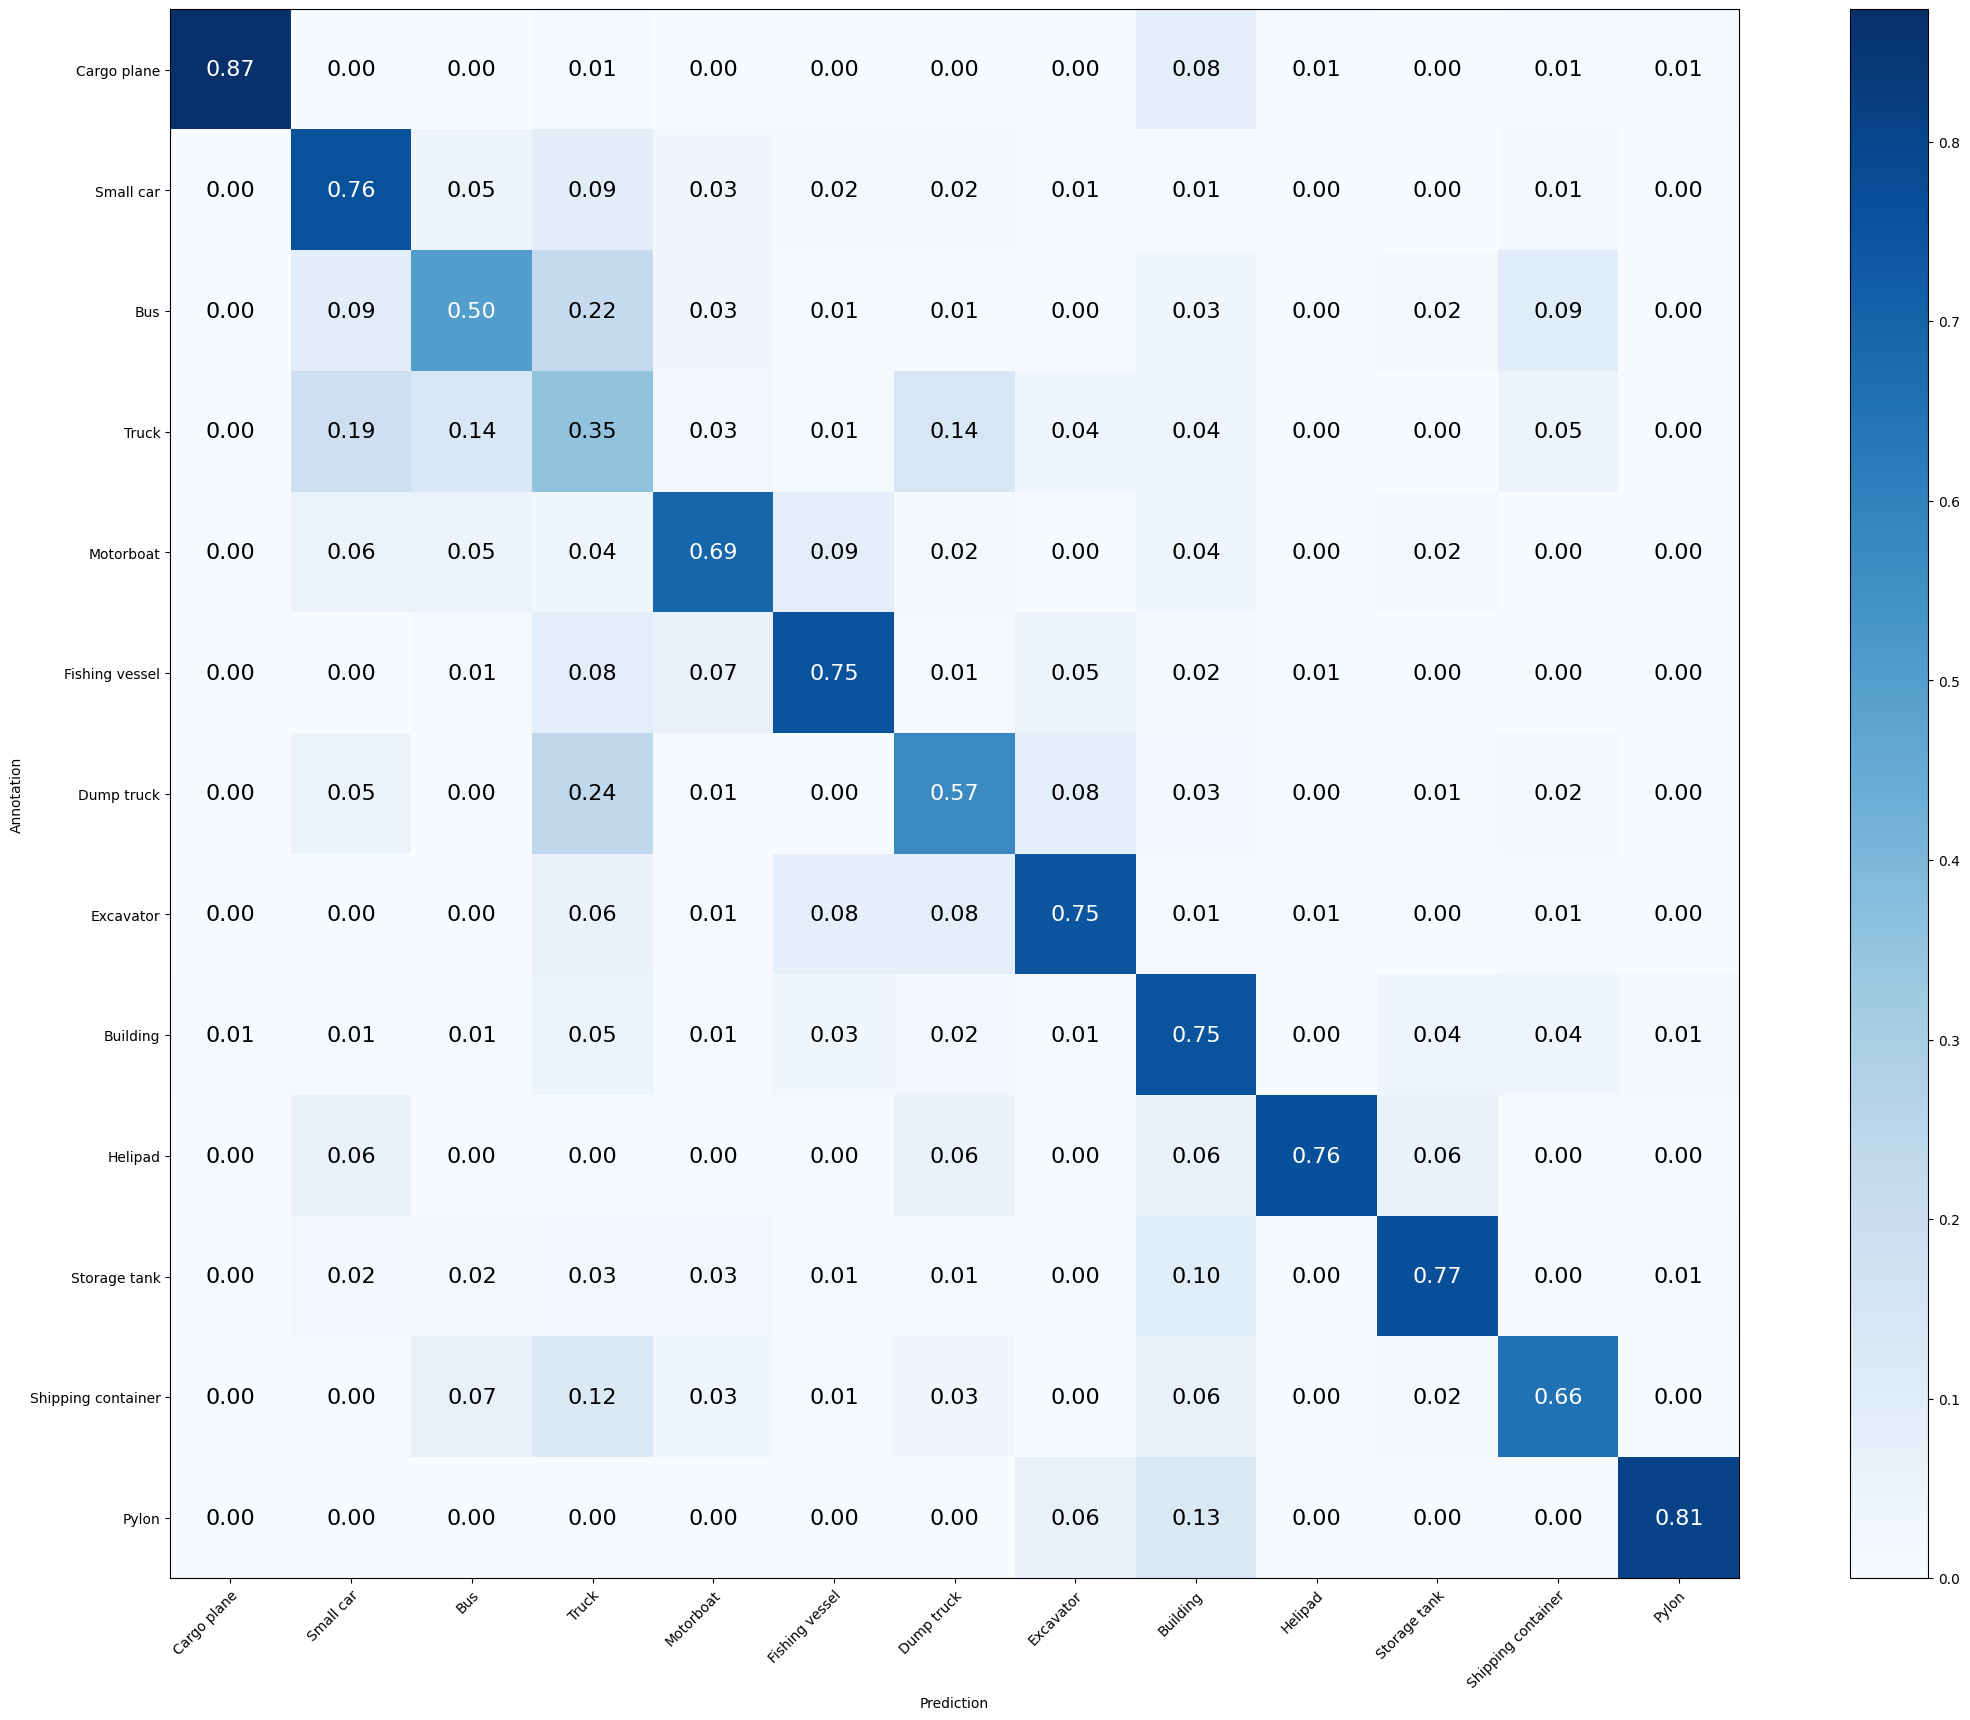

In [18]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [19]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 66.536%
Mean Recall: 69.221%
Mean Precision: 67.646%
> Cargo plane: Recall: 87.368% Precision: 95.402% Specificity: 99.853% Dice: 91.209%
> Small car: Recall: 75.952% Precision: 76.258% Specificity: 94.898% Dice: 76.104%
> Bus: Recall: 49.811% Precision: 55.696% Specificity: 95.878% Dice: 52.590%
> Truck: Recall: 35.241% Precision: 33.815% Specificity: 90.766% Dice: 34.513%
> Motorboat: Recall: 69.375% Precision: 64.912% Specificity: 97.738% Dice: 67.069%
> Fishing vessel: Recall: 75.472% Precision: 57.143% Specificity: 97.783% Dice: 65.041%
> Dump truck: Recall: 57.297% Precision: 52.736% Specificity: 96.384% Dice: 54.922%
> Excavator: Recall: 74.576% Precision: 66.165% Specificity: 98.330% Dice: 70.120%
> Building: Recall: 75.139% Precision: 81.325% Specificity: 95.908% Dice: 78.110%
> Helipad: Recall: 76.471% Precision: 72.222% Specificity: 99.821% Dice: 74.286%
> Storage tank: Recall: 76.818% Precision: 81.643% Specificity: 98.534% Dice: 79.157%
> Shipping container:

#### Testing
Try to improve the results provided in the competition.

In [20]:
import os
import numpy as np

anns = []
root_dir = './xview_recognition/'
test_dir = os.path.join(root_dir, 'xview_test')
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    for filename in filenames:
        rel_dir = os.path.relpath(dirpath, root_dir)
        clean_filename = os.path.join(rel_dir, filename)
        image = GenericImage(clean_filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = os.path.basename(dirpath)
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [21]:
import numpy as np
import tensorflow as tf

predictions_data = {"images": {}, "annotations": {}}
all_test_images = []
metadata = [] 
ann_id = 0

print("Préparation des images de test...")
for idx, ann in enumerate(anns):
    image_data = {
        "image_id": ann.filename.split('/')[-1],
        "filename": ann.filename,
        "width": int(ann.tile[2]),
        "height": int(ann.tile[3])
    }
    predictions_data["images"][idx] = image_data

    image_raw = load_geoimage(ann.filename)
    image_tensor = tf.convert_to_tensor(image_raw)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    image_resized = tf.image.resize(image_tensor, [32,32], method='bicubic')
    img_final = image_resized.numpy()

    for obj_pred in ann.objects:
        all_test_images.append(img_final)
        metadata.append({
            "image_id": ann.filename.split('/')[-1],
            "bbox": [int(x) for x in obj_pred.bb]
        })

if all_test_images:
    X_test = np.array(all_test_images)
    X_test_hog = get_hog_features(X_test)
    print(f"Prédiction en cours sur {len(X_test)} détections...")

    # Calcul de la moyenne des prédictions des 3 modèles
    all_preds = np.mean([
        model.predict({"img_input": X_test, "hog_input": X_test_hog}, batch_size=128, verbose=1)
        for model in models
    ], axis=0)

    category_names = list(categories.values())

    for i, pred in enumerate(all_preds):
        pred_category = category_names[np.argmax(pred)]

        predictions_data["annotations"][ann_id] = {
            "image_id": metadata[i]["image_id"],
            "category_id": pred_category,
            "bbox": metadata[i]["bbox"]
        }
        ann_id += 1

print("Test terminé.")

Préparation des images de test...
Prédiction en cours sur 2365 détections...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Test terminé.


In [22]:
#for i, model in enumerate(models):
#    model.load_weights(f'model_{i}.keras')

In [23]:
import json
with open('prediction.json', 'w') as f:
    json.dump(predictions_data, f)